In [473]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from datetime import datetime

In [474]:
data_train = pd.read_csv("train.csv", encoding = 'ISO-8859-1', low_memory = False)
data_test = pd.read_csv("test.csv", encoding = 'ISO-8859-1', low_memory = False)

Добавим флаг sample, для train он будет равен 1, для test - 0, также для тестовых данных заполним default нулями

In [475]:
data_train['sample'] = 1
data_test['sample'] = 0
data_test['default'] = 0

обьединим train и test датасеты для обучения

In [476]:
data = data_test.append(data_train, sort=False).reset_index(drop=True)

In [477]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0


In [478]:
data.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'sample', 'default'],
      dtype='object')

### Анализ и подготовка признаков

In [479]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

#### education

видим что есть пропуски в поле education, изучим какие значения и в каком количестве содержится в данном столбце

<AxesSubplot:>

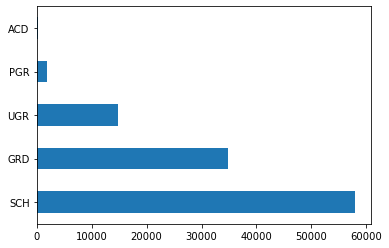

In [480]:
data['education'].value_counts().plot.barh()

In [481]:
round(data.education.value_counts(normalize=True), 2)

SCH    0.53
GRD    0.32
UGR    0.13
PGR    0.02
ACD    0.00
Name: education, dtype: float64

заполним пропуски самым частым типом образования

In [482]:
recent_edu = data['education'].value_counts().index[0]
data['education'].fillna(recent_edu, inplace=True)

Cделаем из education столбца dummy-переменные и после удалим education и одну избыточную dummy переменную

In [483]:
dummies_edu = pd.get_dummies(data.education)
data = pd.merge(data, dummies_edu, left_index=True, right_index=True)
data.drop(['education'], axis=1, inplace=True)
data.drop(['ACD'], axis=1, inplace=True)

In [484]:
data.head()

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,income,sna,first_time,foreign_passport,sample,default,GRD,PGR,SCH,UGR
0,74835,22MAR2014,M,29,Y,Y,0,0,-2.271884,3,...,50000,1,4,N,0,0,1,0,0,0
1,17527,24JAN2014,F,39,N,N,5,0,-1.504999,2,...,5000,4,3,N,0,0,0,0,1,0
2,75683,23MAR2014,M,50,Y,Y,0,0,-1.691339,1,...,30000,1,3,Y,0,0,0,0,0,1
3,26883,03FEB2014,M,56,N,N,0,0,-2.374182,1,...,17000,1,3,N,0,0,0,0,1,0
4,28862,04FEB2014,F,38,N,N,0,0,-2.487502,0,...,120000,1,3,N,0,0,1,0,0,0


#### app_date

app_date содержит строковое представление даты, необходимо преобразовать к типу datetime

In [485]:
data.app_date = pd.to_datetime(data.app_date, format='%d%b%Y')

In [486]:
start = data.app_date.min()
end = data.app_date.max()
start, end

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

In [487]:
data['days'] = (data.app_date - start).dt.days.astype('int')

In [488]:
data.drop(['app_date'], axis=1, inplace=True)

In [489]:
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['region_rating', 'home_address', 'work_address', 'sna', 'first_time']
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'income', 'bki_request_cnt']

#### Бинарные признаки

Закодируем бинарные признаки, чтобы модель могла их обработать. Для этого будем использовать LabelEncoder.

In [490]:
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

data.head()

,client_id,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,...,sna,first_time,foreign_passport,sample,default,GRD,PGR,SCH,UGR,days
0,74835,1,29,1,1,0,0,-2.271884,3,50,...,1,4,0,0,0,1,0,0,0,80
1,17527,0,39,0,0,5,0,-1.504999,2,50,...,4,3,0,0,0,0,0,1,0,23
2,75683,1,50,1,1,0,0,-1.691339,1,50,...,1,3,1,0,0,0,0,0,1,81
3,26883,1,56,0,0,0,0,-2.374182,1,40,...,1,3,0,0,0,0,0,1,0,33
4,28862,0,38,0,0,0,0,-2.487502,0,80,...,1,3,0,0,0,1,0,0,0,34


#### Категориальные признаки

In [491]:
label_encoder = LabelEncoder()

for column in cat_cols:
    data[column] = label_encoder.fit_transform(data[column])

Оценим значимость бинарных и категориальных признаков

<AxesSubplot:>

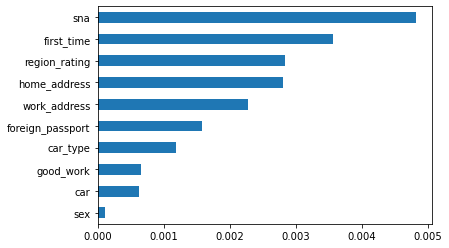

In [492]:
imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features=True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Наиболее важный признак sna, наименее - sex.
Преобразуем категориальные признаки в dummy-переменные.

In [493]:
data = pd.get_dummies(data, columns=cat_cols, dummy_na=False, dtype='uint8')

#### Числовые признаки

Рассмотрим числовые признаки

#### age

/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

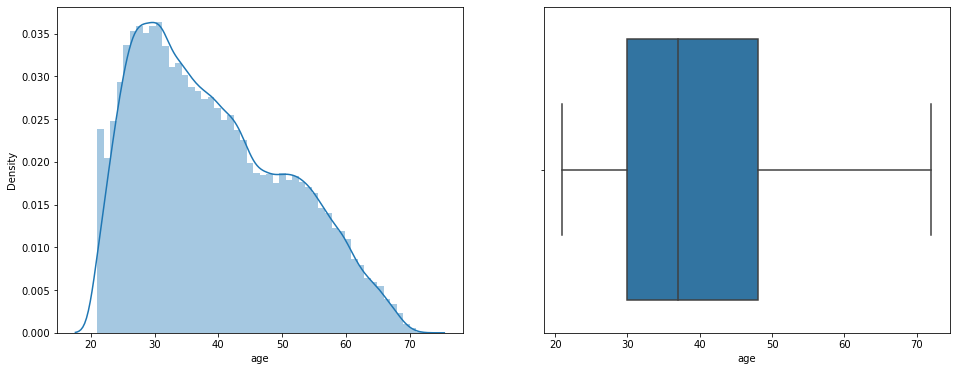

In [494]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.distplot(data.age)
plt.subplot(1, 2, 2)
sns.boxplot(data.age)
plt.show

/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

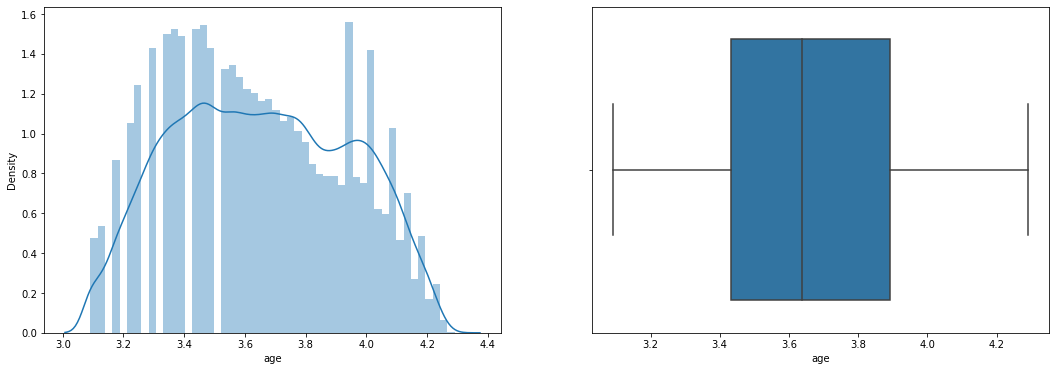

In [495]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
sns.distplot(np.log(data.age + 1))
plt.subplot(1, 2, 2)
sns.boxplot(np.log(data.age + 1))
plt.show

Видно что логарифмирование значений параметра дает более нормальное распределение. Выбросы отсутствуют.

#### decline_app_cnt

<function matplotlib.pyplot.show(close=None, block=None)>

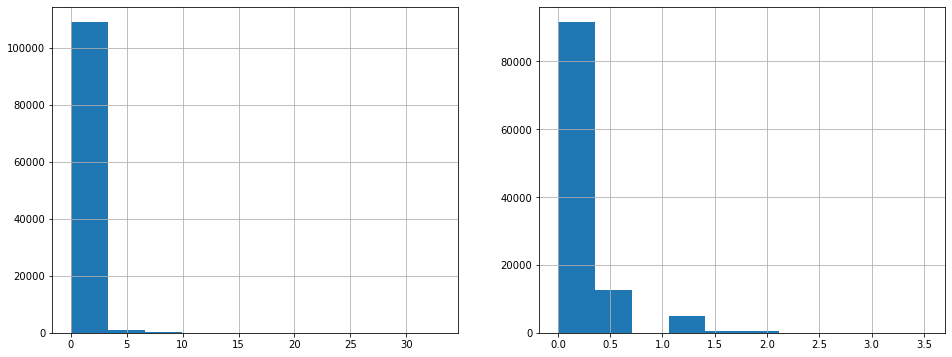

In [496]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
data.decline_app_cnt.hist()
plt.subplot(1, 2, 2)
(np.log(data.decline_app_cnt + 1)).hist()
plt.show

#### score_bki

/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

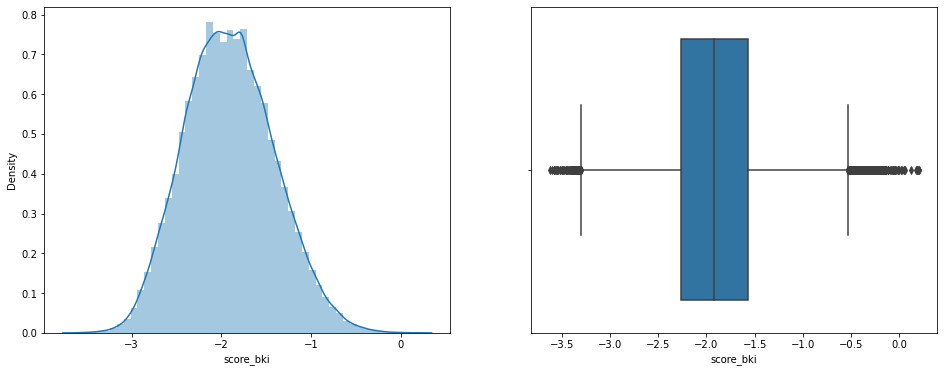

In [497]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.distplot(data.score_bki)
plt.subplot(1, 2, 2)
sns.boxplot(data.score_bki)
plt.show

Видим что признак имеет нормальное распределение. Есть большое количество выбросов. Пока будем строить модель без изменения данного параметра.

#### income

/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

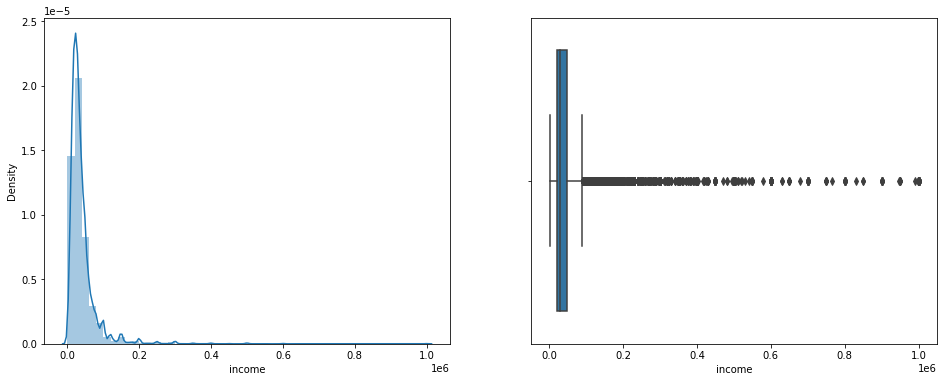

In [498]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.distplot(data.income)
plt.subplot(1, 2, 2)
sns.boxplot(data.income)
plt.show

/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

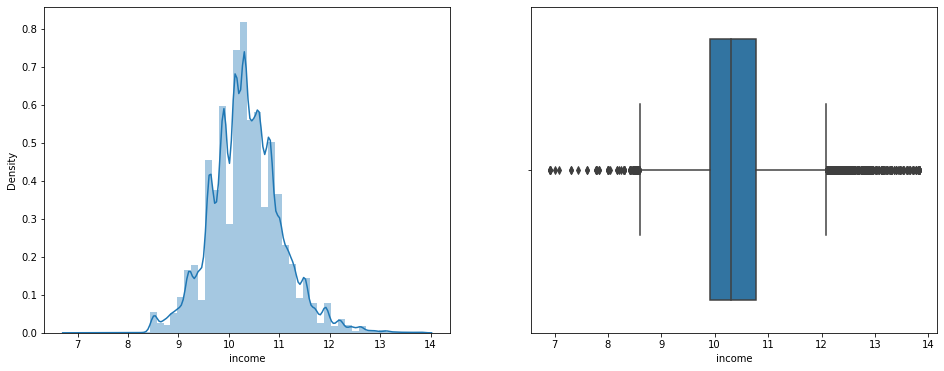

In [499]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.distplot(np.log(data.income + 1))
plt.subplot(1, 2, 2)
sns.boxplot(np.log(data.income + 1))
plt.show

Видим, что логарифмирование значений параметра дает более нормальное распределение. Присутствует много выбросов. Удалять пока не будем, а построим модель с ними.

#### bki_request_cnt

<function matplotlib.pyplot.show(close=None, block=None)>

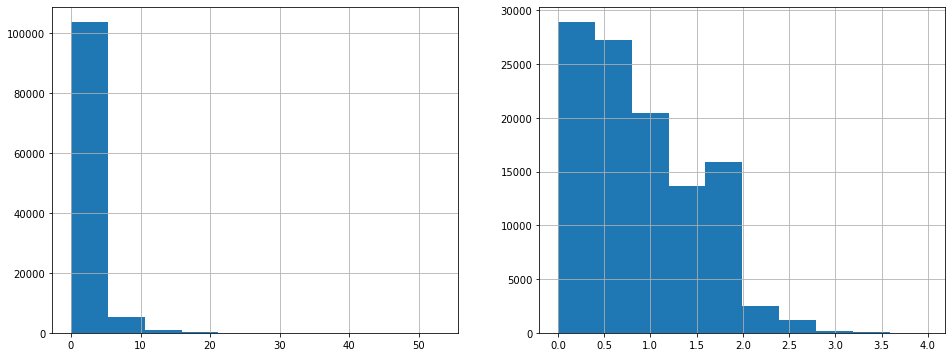

In [500]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
data.bki_request_cnt.hist()
plt.subplot(1, 2, 2)
(np.log(data.bki_request_cnt + 1)).hist()
plt.show

Построим матрицу корреляций числовых признаков

In [501]:
data.age = np.log(data.age + 1)
data.income = np.log(data.income + 1)
data.decline_app_cnt = np.log(data.decline_app_cnt + 1)
data.bki_request_cnt = np.log(data.bki_request_cnt + 1)

<AxesSubplot:>

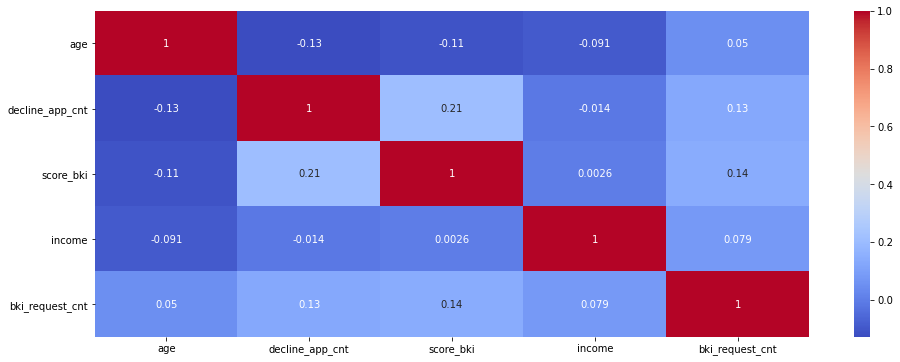

In [502]:
correlation = data[num_cols].corr()
plt.figure(figsize=(16, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

Сильной корреляции между признаками нет, поэтому будем строить модель со всеми признаками.

In [504]:
train = data.query('sample == 1').drop(['sample', 'client_id'], axis=1)
test = data.query('sample == 0').drop(['sample', 'client_id'], axis=1)

y = train.default.values
X = train.drop(['default'], axis=1)

In [505]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


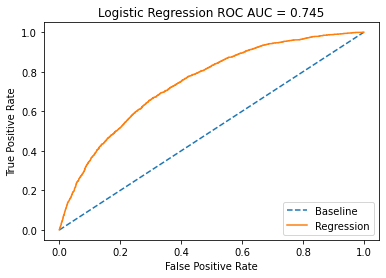

In [506]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]
y_pred = model.predict(X_test)


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

<AxesSubplot:>

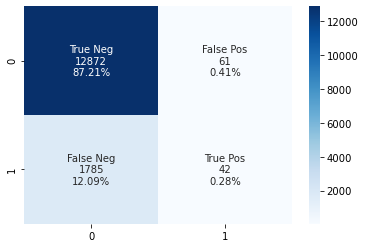

In [507]:
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

Таким образом модель может определить 87% заемщиков которые вернут деньги банку, но при этом мы пропустим 12% заемщиков, у которых случится дефолт. Этот показатель попробуем улучшить с помощью подбора гиперпараметров.

In [508]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty, max_iter=[50], tol=[1e-3])

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/andrew/opt

/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/andrew/opt

/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/andrew/opt

/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Лучшее Penalty: l2
Лучшее C: 166.81005372000593


/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


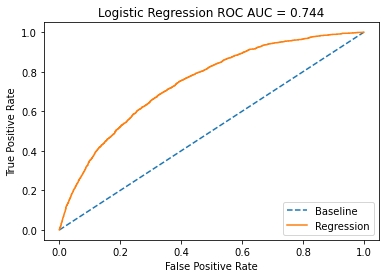

In [509]:
model2 = LogisticRegression(penalty=best_model.best_estimator_.get_params()['penalty'], 
                            C=best_model.best_estimator_.get_params()['C'], max_iter=50,
                            class_weight='balanced', tol=0.001, random_state=42, solver='sag')
model2.fit(X_train, y_train)

y_pred_prob = model2.predict_proba(X_test)[:, 1]
y_pred = model2.predict(X_test)


fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

<AxesSubplot:>

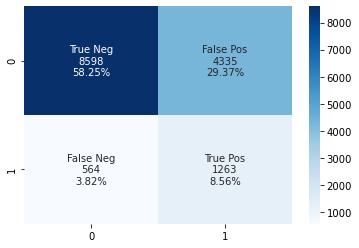

In [510]:
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

Модель стала работать иначе в определении надежности клиента. Теперь процент пропуска неблагополучных заемщиков стал меньше, но снизился процент правильного определения благонадежных заемщиков, что может привести к недополучению прибыли банком.

In [511]:
X_test = test.drop(['default'], axis=1)

In [512]:
y_pred_prob = model2.predict_proba(X_test)[:, 1]

submit = pd.DataFrame(data_test.client_id)
submit['default'] = y_pred_prob
submit.to_csv('submission.csv', index=False)